# Prévision des finances sur la base des données

L'objectif est de construire un modèle capable de prédire sur les cinq prochaines années les finances dans un domaine (indicateur) donné.

In [1]:
import pandas as pd 
import re
import spacy as sp
import matplotlib.pyplot as plt
import numpy as np


## Préparation et exploration des données

In [2]:
# Lecture du csv
donnees = pd.read_csv("data/TGO.csv", skiprows=4)

# Affichage des données chargées
donnees

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Togo,TGO,"Intentional homicides, male (per 100,000 male)",VC.IHR.PSRC.MA.P5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Togo,TGO,Battle-related deaths (number of people),VC.BTL.DETH,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.400000e+01,2.600000e+01,NaN,NaN
2,Togo,TGO,Voice and Accountability: Percentile Rank,VA.PER.RNK,NaN,NaN,NaN,NaN,NaN,NaN,...,3.152709e+01,2.906404e+01,2.621359e+01,2.705314e+01,2.801932e+01,2.657005e+01,2.753623e+01,2.647059e+01,NaN,NaN
3,Togo,TGO,Transport services (% of commercial service ex...,TX.VAL.TRAN.ZS.WT,NaN,NaN,NaN,NaN,NaN,NaN,...,4.352915e+01,3.947473e+01,3.751170e+01,3.723193e+01,3.787760e+01,NaN,NaN,NaN,NaN,NaN
4,Togo,TGO,"Computer, communications and other services (%...",TX.VAL.OTHR.ZS.WT,NaN,NaN,NaN,NaN,NaN,NaN,...,3.050142e+01,3.206887e+01,3.272817e+01,3.188613e+01,3.920251e+01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,Togo,TGO,Adjusted savings: carbon dioxide damage (% of ...,NY.ADJ.DCO2.GN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.359561e+00,1.210120e+00,1.269051e+00,1.334426e+00,1.262783e+00,1.202721e+00,NaN,NaN,NaN,NaN
1505,Togo,TGO,"Services, value added (% of GDP)",NV.SRV.TOTL.ZS,NaN,NaN,NaN,1.728398e+01,2.031254e+01,2.367815e+01,...,5.035119e+01,5.054652e+01,5.053120e+01,5.123722e+01,5.133959e+01,5.141925e+01,5.107844e+01,5.172739e+01,NaN,NaN
1506,Togo,TGO,"Services, value added (current LCU)",NV.SRV.TOTL.CN,NaN,NaN,NaN,8.567367e+09,1.167495e+10,1.534817e+10,...,1.811540e+12,1.874720e+12,1.972940e+12,2.099240e+12,2.186810e+12,2.378670e+12,2.602850e+12,2.877600e+12,NaN,NaN
1507,Togo,TGO,Medium and high-tech manufacturing value added...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Récupération du champs : Merchandise exports (current US$)

to_analyse = donnees[donnees["Indicator Name"] == "Merchandise exports (current US$)"]

to_analyse

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
214,Togo,TGO,Merchandise exports (current US$),TX.VAL.MRCH.CD.WT,15000000.0,19000000.0,17000000.0,18000000.0,30000000.0,27000000.0,...,1.036000e+09,1.016000e+09,1.080000e+09,1.055000e+09,979000000.0,1.060000e+09,1.348000e+09,1.456000e+09,NaN,NaN


In [4]:
# Transformation en un df long en ne conservant que les dates et les valeurs correspondantes
df_long = to_analyse.melt(
    value_vars = [str(y) for y in range(1960, 2025)],
    var_name = "annee",
    value_name = "valeur"
)

# Affichage
#df_long

# Suppression des lignes contenant des colonnes vides
df_long = df_long.dropna()

df_long

,annee,valeur
0,1960,1.500000e+07
1,1961,1.900000e+07
2,1962,1.700000e+07
3,1963,1.800000e+07
4,1964,3.000000e+07
...,...,...
59,2019,1.055000e+09
60,2020,9.790000e+08
61,2021,1.060000e+09
62,2022,1.348000e+09


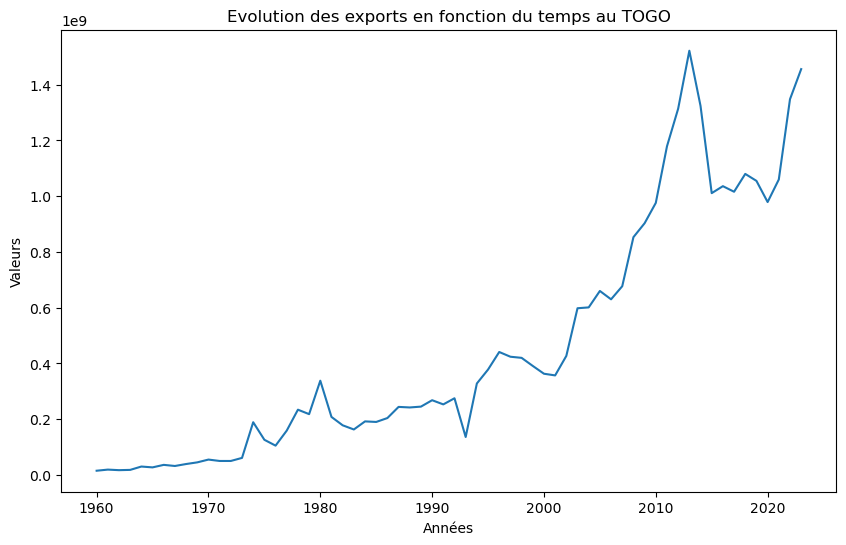

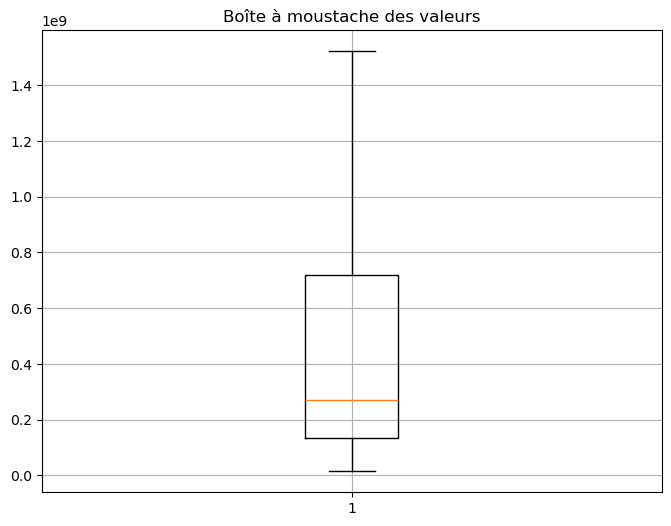

In [10]:
# Affichage de l'évolution en fonction du temps
df_long["annee"] = df_long["annee"].astype(int)

plt.figure(figsize=(10, 6)) # Pour avoir une figure plus grande
plt.plot(df_long["annee"], df_long["valeur"])
plt.title("Evolution des exports en fonction du temps au TOGO")
plt.xlabel("Années")
plt.ylabel("Valeurs")
plt.show()


# Tracé de la boite à moustache
plt.figure(figsize=(8,6))
plt.boxplot(df_long["valeur"])
plt.title("Boîte à moustache des valeurs")
plt.grid(True)
plt.show()

In [9]:
# Quelques statistiques sur les donnéees
valeurs = df_long["valeur"]

moyenne = np.mean(valeurs)
ecart_type = np.std(valeurs)
mediane = np.median(valeurs)

# Tranformation en df et affichage
data = [moyenne, ecart_type, mediane, max(valeurs), min(valeurs)]
statistiques = pd.DataFrame([data])
statistiques.columns = ["Moyenne", "Ecart-type", "Médiane", "Maximun", "Minimum"]

statistiques

,Moyenne,Ecart-type,Médiane,Maximun,Minimum
0,460437500.0,4.310947e+08,271500000.0,1.522000e+09,15000000.0
